In [1]:
# run in one batch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# scipy imports
import scipy.stats as stats

# sklearn imports
from sklearn.linear_model import LinearRegression

In [30]:
# define cleaning functions
def clean_q_data(dataframe):
    ''' 
    input: dataframe with re-named columns
    output: dataframe
    '''
    # datetime operations
    q_df['dt'] = pd.to_datetime(q_df['dt_string'])
    q_df['year'] = q_df['dt'].dt.year
    q_df['month'] = q_df['dt'].dt.month
    q_df['day'] = q_df['dt'].dt.day

    # new datetime without time
    q_df['timestamp'] = pd.to_datetime(q_df[['year','month', 'day']], errors='coerce')

    # make series from groupby, this has timestamp as index
    daily_q = q_df.groupby(['timestamp'])['cfs'].mean()

    # make df from series
    daily_q_df = pd.DataFrame(daily_q)
    return(daily_q_df)

def clean_snow_data(dataframe):
    ''' 
    input: dataframe with re-named columns
    output: dataframe
    '''
    # unit conversions to metric
    snow_df['swe_start_m'] = snow_df.swe_start_in * 0.0254
    snow_df['airtemp_max_C'] = 5/9*(snow_df.airtemp_max_F - 32)
    snow_df['airtemp_min_C'] = 5/9*(snow_df.airtemp_min_F - 32)
    snow_df['airtemp_mean_C'] = 5/9*(snow_df.airtemp_mean_F - 32)
    snow_df['precip_start_m'] = snow_df.precip_start_in * 0.0254
    snow_df['precip_incr_m'] = snow_df.precip_incr_in * 0.0254
    
    # drop standard unit columns
    snow_df.drop(['swe_start_in'], axis=1, inplace=True)
    snow_df.drop(['airtemp_max_F'], axis=1, inplace=True)
    snow_df.drop(['airtemp_min_F'], axis=1, inplace=True)
    snow_df.drop(['airtemp_mean_F'], axis=1, inplace=True)
    snow_df.drop(['precip_start_in'], axis=1, inplace=True)
    snow_df.drop(['precip_incr_in'], axis=1, inplace=True)
    
    # datetime operations
    snow_df['dt'] = pd.to_datetime(snow_df['date'])
    snow_df['year'] = snow_df['dt'].dt.year
    
    # remove rows with swe=0
    snow_df.drop(snow_df[snow_df.swe_start_m == 0].index, inplace=True)

    #set snow df index to dt
    snow_df.set_index(snow_df.dt, inplace=True)
    return(snow_df)

def clean_outliers(df):
    ''' 
    input: dataframe with re-named columns
    output: dataframe
    '''
    # clear min airtemp outliers
    df.drop(df[df.airtemp_min_C > 18].index, inplace=True)
    df.drop(df[df.airtemp_min_C < -40].index, inplace=True)
    # clear max airtemp outliers
    df.drop(df[df.airtemp_max_C > 50].index, inplace=True)
    df.drop(df[df.airtemp_max_C < -45].index, inplace=True)
    return(df)

In [ ]:
    # annual peak Q
    #peak_q = q_df.groupby(q_df.year)['cfs'].max()

    # cumulative Q
    #sum_q = q_df.groupby(q_df.year)['cfs'].cumsum()
    
    # annual peak swe
    #peak_swe = snow_df.groupby(snow_df.year)['swe_start_in'].max()

    # annual sum swe
    #sum_swe = snow_df.groupby(snow_df.year)['swe_start_in'].cumsum()

In [6]:
# load q data
q_df = pd.read_csv('q-data/gunnison_delta.csv',sep='\t',header=32) # read csv to dataframe
q_df.columns = ['USGS', 'id', 'dt_string', 'tz', 'cfs', 'junk'] # rename columns

daily_q_df = clean_q_data(q_df)

In [7]:
# load snotel data
stationnames = ['680_park_cone','762_slumgullion','701_porphyry_creek','737_schofield_pass','682_park_reservoir',
                '669_north_lost_trail','1059_cochetopa_pass']
data_lst = []
count = 0
for stationname in stationnames:
    snow_df = pd.read_csv('snotel-data/snotel_{}.csv'.format(stationname),header=58) 
    snow_df.columns = ['date', 'swe_start_in',
       'precip_start_in',
       'airtemp_max_F', 'airtemp_min_F',
       'airtemp_mean_F', 'precip_incr_in']
    # clean snow data
    snow_df = clean_snow_data(snow_df)
    # merge datasets
    merged_df = pd.merge(snow_df, daily_q_df, how='left', left_index=True, right_index=True)

    data_lst.append(merged_df)
    count += 1
print(count)
data_df = pd.concat(data_lst, axis=0, ignore_index = True)

7


In [31]:
# clean outliers
data_clean = clean_outliers(data_df)

In [39]:
data_df.head()

,date,precip_start_in,precip_incr_in,airtemp_max_C,airtemp_min_C,airtemp_mean_C,swe_start_m,dt,year,cfs,bins
0,1980-03-30,2.0,NaN,NaN,NaN,NaN,NaN,1980-03-30,1980,NaN,NaN
1,1980-03-31,NaN,NaN,NaN,NaN,NaN,NaN,1980-03-31,1980,NaN,NaN
2,1980-04-01,NaN,NaN,NaN,NaN,NaN,NaN,1980-04-01,1980,NaN,NaN
3,1980-04-02,NaN,NaN,NaN,NaN,NaN,NaN,1980-04-02,1980,NaN,NaN
4,1980-04-03,NaN,NaN,NaN,NaN,NaN,NaN,1980-04-03,1980,NaN,NaN


In [32]:
# bin by min temp
disc = 0.5 # discretization to bin, in degrees C
bin_idxs = np.arange(data_clean.airtemp_min_C.min(),data_clean.airtemp_min_C.max(),disc,dtype='float')
bins, binvals = pd.cut(data_clean.airtemp_min_C,bin_idxs,right=True,retbins=True)
data_clean['bins'] = bins.values
maxQ_mintemp = data_clean.groupby(data_clean.bins)['cfs'].max()
#ok here

# data for new regression
meanSWE_mintemp = data_clean.groupby(data_clean.bins)['swe_start_m'].mean()
meanAIR_mintemp = data_clean.groupby(data_clean.bins)['airtemp_min_C'].mean()
meanPRECIP_mintemp = data_clean.groupby(data_clean.bins)['precip_start_in'].mean()
data_binned = pd.concat([meanSWE_mintemp,meanAIR_mintemp,meanPRECIP_mintemp,maxQ_mintemp], axis=1)
# ok here

# drop nans
data_clean_binned = data_binned.dropna()


In [37]:
#np.shape(data_clean_binned)

In [38]:
#data_clean_binned.head(10)


In [21]:
#feature engineer -squared terms
model_df = data_clean_binned
model_df['airmin2'] = model_df.airtemp_min_C**2*-1
model_df['airmin3'] = model_df.airtemp_min_C**3
model_df['airmin4'] = model_df.airtemp_min_C**4*-1

In [34]:
model_df.head()

,swe_start_m,airtemp_min_C,precip_start_in,cfs,airmin2,airmin3,airmin4
bins,,,,,,,
"(-36.778, -36.278]",0.403860,-36.666667,19.300000,538.937500,-1344.444444,-49296.296296,-1.807531e+06
"(-36.278, -35.778]",0.289560,-36.111111,13.350000,2512.395833,-1304.012346,-47089.334705,-1.700448e+06
"(-35.778, -35.278]",0.179705,-35.555556,9.300000,1328.333333,-1264.197531,-44949.245542,-1.598195e+06
"(-34.778, -34.278]",0.150223,-34.444444,7.414286,1335.729167,-1186.419753,-40865.569273,-1.407592e+06
"(-34.278, -33.778]",0.281940,-33.888889,12.633333,1805.208333,-1148.456790,-38919.924554,-1.318953e+06


R2 = 0.926


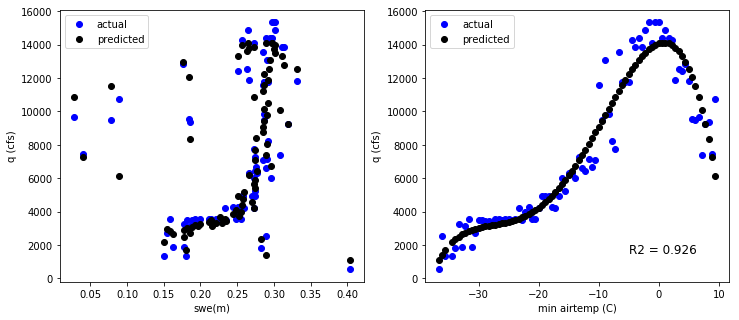

In [36]:
#model_df = data_clean_binned
cols = model_df.columns
# regression
X = model_df[['airtemp_min_C','airmin2','airmin3', 'airmin4']]
y = model_df['cfs']

model = LinearRegression()
model.fit(X,y)
y_hat = model.predict(X)

# R2 score
score = model.score(X,y)
print('R2 = {0:.3f}'.format(score))

# plot predictions
# plots swe A, B
fig, ax = plt.subplots(1,2,figsize=(12,5));
ax[0].plot(data_clean_binned.swe_start_m,y,'bo')
ax[0].set_ylabel('q (cfs)');
ax[0].set_xlabel('swe(m)')
ax[0].plot(data_clean_binned.swe_start_m,y_hat,'ko')
ax[0].legend(['actual','predicted'])

ax[1].plot(data_clean_binned.airtemp_min_C,y,'bo')
ax[1].set_ylabel('q (cfs)');
ax[1].set_xlabel('min airtemp (C)')
ax[1].plot(data_clean_binned.airtemp_min_C,y_hat,'ko')
ax[1].legend(['actual','predicted'])

figname = 'gunnison_river_7stations_poly4_C'
plt.text(-5,1500,'R2 = {0:.3f}'.format(score),fontsize=12)
plt.savefig('{}.pdf'.format(figname),format='pdf')

In [ ]:
np.shape(X)

In [ ]:
np.shape(y)

In [ ]:
X.head()
